In [1]:
import numpy as np
from scipy.sparse.linalg import cg
import math
from scipy.sparse import csr_matrix
import numpy as np
import json
import time
import hashlib
import threading
from puzzle_generation.tlp_lattice import generate_puzzle, solve_puzzle

In [4]:
T = 4500 # 440 == 1s of execution
message = b"This is a secret msg for HHL!"

print("[*] Generating puzzle...")
puzzle = generate_puzzle(T, message)
with open("./puzzle_generation/puzzle.json", "w") as f:
    json.dump(puzzle, f)

print("[*] Puzzle generated and saved to 'puzzle.json'.")
print("    Ciphertext:", puzzle['ciphertext'])

print("[*] Solving puzzle...")
with open("./puzzle_generation/puzzle.json", "r") as f:
    loaded_puzzle = json.load(f)

recovered = solve_puzzle(loaded_puzzle)
print("    Recovered Message:", recovered.decode())

[*] Generating puzzle...
[*] Puzzle generated and saved to 'puzzle.json'.
    Ciphertext: 6a91c788444a39602b79d11f67a3a286fb850e7c5e8c31213b617656cc
[*] Solving puzzle...
    Recovered Message: This is a secret msg for HHL!


## CGM

Complexity: $$ O(Nsk \log{(\frac{1}{\epsilon})}) $$

s = Sparsity, k = Condition number (ratio of largest to smalelst eigenvalue), N = size of matrix (NxN) 

- For CGM, if the matrix is not symmetric, it most likely won't converge to a value

In [217]:

N = 9000
A_matrix = np.random.rand(N, N)

# for making it sparse
# mask = np.random.rand(N, N) < 0.1
# A_matrix = A_matrix * mask


A_matrix = A_matrix + A_matrix.T # symmetric 
b_vector = np.random.rand(N, 1)

T = int(4400 * (6.47e-07) * N**2.1) # Use small T for demonstration; large T will increase delay
message = b"This is a secret msg for HHL!"

print("[*] Generating puzzle...")
puzzle = generate_puzzle(T, message)
with open("./puzzle_generation/puzzle.json", "w") as f:
    json.dump(puzzle, f)

[*] Generating puzzle...


In [ ]:

# A_csr = csr_matrix(A_matrix)

start_time = time.time()
x, exit_code = cg(A_matrix, b_vector)
end_time = time.time()

execution_time = end_time - start_time
print(f"CGM Execution Time: {execution_time:.6f} seconds")

print("[*] Solving puzzle...")
with open("./puzzle_generation/puzzle.json", "r") as f:
    loaded_puzzle = json.load(f)

start_time = time.time()
recovered = solve_puzzle(loaded_puzzle)
end_time = time.time()

execution_time = end_time - start_time
print(f"TLP Execution Time: {execution_time:.6f} seconds")


# print("Condition:", np.linalg.cond(A_matrix))
# eigvals = np.linalg.eigvals(A_matrix)
# print("sparsity of Matrix A:", 1 - np.count_nonzero(A_matrix) / A_matrix.size)
x

CGM Execution Time: 270.874663 seconds
[*] Solving puzzle...
TLP Execution Time: 127.536739 seconds
TLP Execution Time: 127.536739 seconds


array([ 50.68601105, -68.51772322,  25.9572533 , ..., -17.11028108,
        62.81864351, -46.11937202])

## Time-Lock Puzzle Performance Experiment
Measuring execution time for different T values (iteration counts)

In [137]:
import matplotlib.pyplot as plt

# Test T values - using powers of 2 and 3 for systematic testing
# Starting small to avoid extremely long execution times
T_values_pow2 = [2**i for i in range(6, 15)]  # 64, 128, 256, ..., 16384
# T_values_pow3 = [3**i for i in range(4, 10)]  # 81, 243, 729, ..., 19683

# Combine and sort
T_values = sorted(set(T_values_pow2 ))

num_trials = 10  # Number of trials per T value for averaging
test_message = b"Test message for TLP"

# Store results
tlp_times = []
tlp_T_tested = []

print("=" * 70)
print("TIME-LOCK PUZZLE PERFORMANCE EXPERIMENT")
print("=" * 70)
print(f"Testing {len(T_values)} different T values with {num_trials} trials each")
print(f"{'T Value':<15} {'Avg Time (s)':<15} {'Status'}")
print("-" * 70)

for T in T_values:
    trial_times = []
    
    for trial in range(num_trials):
        try:
            # Generate and solve puzzle
            puzzle = generate_puzzle(T, test_message)
            start_time = time.time()
            recovered = solve_puzzle(puzzle)
            end_time = time.time()
            
            execution_time = end_time - start_time
            trial_times.append(execution_time)
            
            # Verify correctness
            if recovered != test_message:
                print(f"{T:<15} {'ERROR':<15} ✗ Message mismatch")
                break
                
        except Exception as e:
            print(f"{T:<15} {'ERROR':<15} ✗ {str(e)[:30]}")
            break
    
    if trial_times and len(trial_times) == num_trials:
        avg_time = np.mean(trial_times)
        std_time = np.std(trial_times)
        tlp_times.append(avg_time)
        tlp_T_tested.append(T)
        
        print(f"{T:<15} {avg_time:<15.6f} ✓ (±{std_time:.6f}s)")
    
print("-" * 70)
print(f"Completed: {len(tlp_T_tested)}/{len(T_values)} T values tested successfully")
print("=" * 70)

TIME-LOCK PUZZLE PERFORMANCE EXPERIMENT
Testing 9 different T values with 10 trials each
T Value         Avg Time (s)    Status
----------------------------------------------------------------------
64              0.014945        ✓ (±0.000220s)
64              0.014945        ✓ (±0.000220s)
128             0.029270        ✓ (±0.000396s)
128             0.029270        ✓ (±0.000396s)
256             0.058097        ✓ (±0.000740s)
256             0.058097        ✓ (±0.000740s)
512             0.114874        ✓ (±0.001338s)
512             0.114874        ✓ (±0.001338s)
1024            0.227618        ✓ (±0.001812s)
1024            0.227618        ✓ (±0.001812s)


KeyboardInterrupt: 

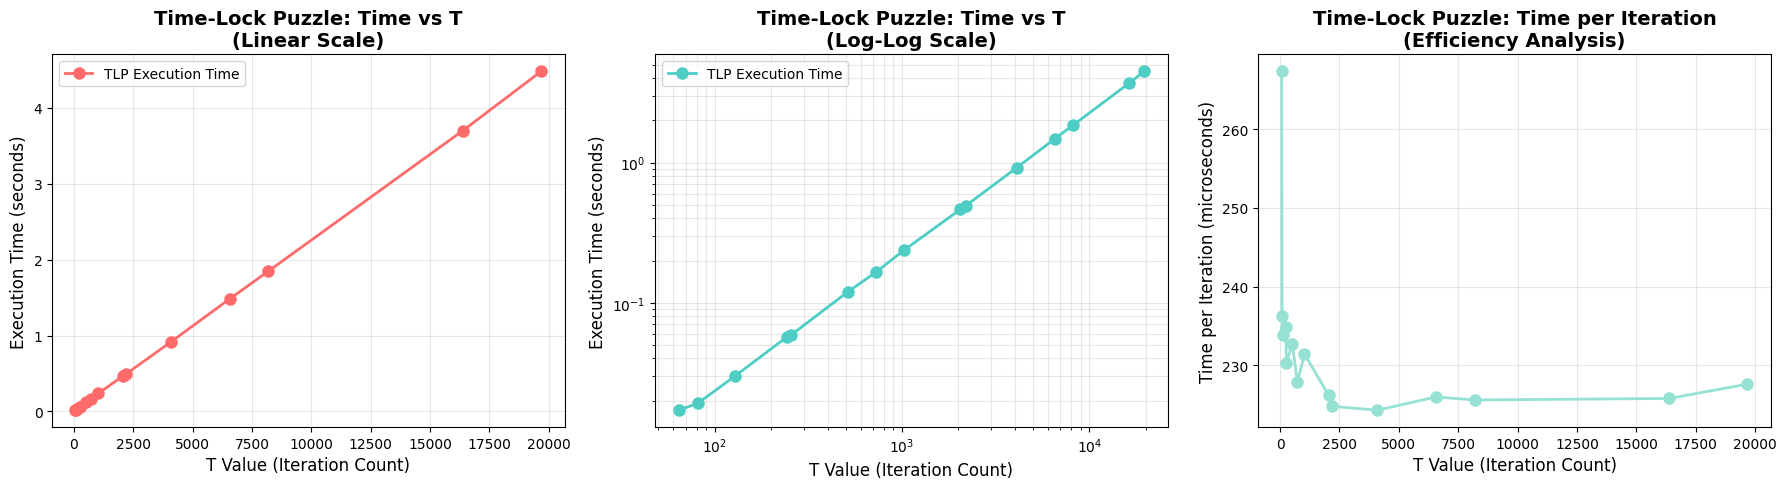


SUMMARY STATISTICS
T Value Range: 64 to 19,683
Time Range: 0.017109s to 4.480330s

Average time per iteration: 231.671 microseconds
Median time per iteration: 227.857 microseconds
Std dev time per iteration: 10.255 microseconds


In [ ]:
# Plot execution times
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Linear scale
ax1 = axes[0]
ax1.plot(tlp_T_tested, tlp_times, 'o-', linewidth=2, markersize=8, color='#FF6B6B', label='TLP Execution Time')
ax1.set_xlabel('T Value (Iteration Count)', fontsize=12)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('Time-Lock Puzzle: Time vs T\n(Linear Scale)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Log-log scale
ax2 = axes[1]
ax2.loglog(tlp_T_tested, tlp_times, 'o-', linewidth=2, markersize=8, color='#4ECDC4', label='TLP Execution Time')
ax2.set_xlabel('T Value (Iteration Count)', fontsize=12)
ax2.set_ylabel('Execution Time (seconds)', fontsize=12)
ax2.set_title('Time-Lock Puzzle: Time vs T\n(Log-Log Scale)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=10)

# Plot 3: Time per iteration
ax3 = axes[2]
time_per_iteration = np.array(tlp_times) / np.array(tlp_T_tested)
ax3.plot(tlp_T_tested, time_per_iteration * 1e6, 'o-', linewidth=2, markersize=8, color='#95E1D3')
ax3.set_xlabel('T Value (Iteration Count)', fontsize=12)
ax3.set_ylabel('Time per Iteration (microseconds)', fontsize=12)
ax3.set_title('Time-Lock Puzzle: Time per Iteration\n(Efficiency Analysis)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"T Value Range: {min(tlp_T_tested):,} to {max(tlp_T_tested):,}")
print(f"Time Range: {min(tlp_times):.6f}s to {max(tlp_times):.6f}s")
print(f"\nAverage time per iteration: {np.mean(time_per_iteration)*1e6:.3f} microseconds")
print(f"Median time per iteration: {np.median(time_per_iteration)*1e6:.3f} microseconds")
print(f"Std dev time per iteration: {np.std(time_per_iteration)*1e6:.3f} microseconds")
print("=" * 70)

### Analyze Time Complexity of Time-Lock Puzzle

In [ ]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

print("=" * 70)
print("TIME COMPLEXITY ANALYSIS - TIME-LOCK PUZZLE")
print("=" * 70)

# Convert to numpy arrays
T_array = np.array(tlp_T_tested)
time_array = np.array(tlp_times)

# Linear regression: T(time) = a * T + b
def linear_model(T, a, b):
    return a * T + b

try:
    # Fit linear model
    params_linear, _ = curve_fit(linear_model, T_array, time_array)
    a, b = params_linear
    
    # Calculate R-squared
    predicted = linear_model(T_array, a, b)
    residuals = time_array - predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((time_array - np.mean(time_array))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print("\nLinear Model: T(time) = a * T + b")
    print("-" * 70)
    print(f"  Coefficient (a): {a:.2e} seconds/iteration")
    print(f"  Intercept (b):   {b:.6f} seconds")
    print(f"  R² score:        {r_squared:.8f}")
    print(f"  Formula:         time ≈ {a:.2e} * T + {b:.6f}")
    
    # Calculate average time per iteration
    avg_time_per_iter = a
    print(f"\n  Average time per iteration: {avg_time_per_iter*1e6:.3f} microseconds")
    print(f"  This is approximately {avg_time_per_iter*1e9:.1f} nanoseconds per iteration")
    
except Exception as e:
    print(f"Linear fit failed: {e}")

# Log-log analysis
print("\n" + "-" * 70)
print("Log-Log Regression Analysis:")
print("-" * 70)

log_T = np.log(T_array)
log_time = np.log(time_array)
slope, intercept, r_value, p_value, std_err = linregress(log_T, log_time)

print(f"  Power law: time ≈ {np.exp(intercept):.2e} * T^{slope:.4f}")
print(f"  Exponent: {slope:.4f}")
print(f"  R² score: {r_value**2:.8f}")

if abs(slope - 1.0) < 0.05:
    complexity_interpretation = "O(T) - Linear (as expected for sequential puzzles)"
else:
    complexity_interpretation = f"Approximately O(T^{slope:.2f})"
    
print(f"  Interpretation: {complexity_interpretation}")

print("\n" + "=" * 70)
print("THEORETICAL vs OBSERVED")
print("=" * 70)
print("Time-lock puzzles should have O(T) complexity (linear in T)")
print(f"Observed exponent: {slope:.4f}")
if abs(slope - 1.0) < 0.1:
    print("✓ MATCHES EXPECTED: The puzzle exhibits linear time complexity")
else:
    print(f"⚠ DEVIATION: Expected ~1.0, observed {slope:.4f}")
    print("  This could be due to overhead, caching, or implementation details")

print("=" * 70)

In [ ]:
# Visualize the linear fit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Linear fit on regular scale
ax1 = axes[0]
ax1.scatter(T_array, time_array, color='blue', s=80, alpha=0.6, label='Measured Times', zorder=3)

if 'params_linear' in locals():
    T_smooth = np.linspace(T_array.min(), T_array.max(), 200)
    ax1.plot(T_smooth, linear_model(T_smooth, *params_linear), 'r-', linewidth=2, 
             label=f'Linear Fit (R²={r_squared:.6f})', zorder=2)
    
ax1.set_xlabel('T Value (Iterations)', fontsize=12)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('Time-Lock Puzzle: Linear Relationship\ntime = a·T + b', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2 = axes[1]
if 'params_linear' in locals():
    residuals = time_array - linear_model(T_array, *params_linear)
    ax2.scatter(T_array, residuals * 1000, color='green', s=80, alpha=0.6)
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Perfect Fit')
    ax2.set_xlabel('T Value (Iterations)', fontsize=12)
    ax2.set_ylabel('Residuals (milliseconds)', fontsize=12)
    ax2.set_title('Residual Analysis\n(Observed - Predicted)', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Extrapolate for larger T values
print("\n" + "=" * 70)
print("TIME PREDICTIONS FOR LARGER T VALUES")
print("=" * 70)
if 'params_linear' in locals():
    print(f"Using model: time ≈ {a:.2e} * T + {b:.6f}\n")
    
    prediction_T_values = [50000, 100000, 500000, 1000000, 10000000]
    print(f"{'T Value':<15} {'Predicted Time':<20} {'In Minutes':<15}")
    print("-" * 70)
    
    for T_pred in prediction_T_values:
        pred_time = linear_model(T_pred, *params_linear)
        minutes = pred_time / 60
        hours = minutes / 60
        
        if hours > 1:
            time_str = f"{hours:.2f} hours"
        elif minutes > 1:
            time_str = f"{minutes:.2f} minutes"
        else:
            time_str = f"{pred_time:.3f} seconds"
            
        print(f"{T_pred:<15,} {pred_time:<20.6f} {time_str:<15}")
    
print("=" * 70)

In [ ]:
print("Condition:", np.linalg.cond(A_matrix))
print("sparsity of Matrix A:",  np.count_nonzero(A_matrix) / A_matrix.size)
eigvals = np.linalg.eigvals(A_matrix)
print(eigvals)


Condition: 1443243.678943111
sparsity of Matrix A: 1.0
[ 8.19066951e+03  7.40683072e+01 -7.38465259e+01 ...  5.53020116e-01
  5.49239962e-01 -6.56203599e-01]
[ 8.19066951e+03  7.40683072e+01 -7.38465259e+01 ...  5.53020116e-01
  5.49239962e-01 -6.56203599e-01]


## CGM Performance Experiment
Measuring execution time for different matrix sizes N = 4, 8, 16, 32, ..., 4096

In [ ]:
import time
import matplotlib.pyplot as plt

# Matrix sizes: powers of 2 from 4 to 4096
matrix_sizes = [2**i for i in range(2, 11)]  # 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096
num_trials = 10

# Store average times
average_times = []

print("Running CGM experiments...")
print(f"{'N':<10} {'Avg Time (s)':<15} {'Status'}")
print("-" * 40)

for N in matrix_sizes:
    trial_times = []
    
    for trial in range(num_trials):
        # Generate random symmetric matrix and vector
        A_matrix = np.random.rand(N, N)
        A_matrix = A_matrix + A_matrix.T  # Make symmetric
        b_vector = np.random.rand(N)
        
        # Measure CGM execution time
        start_time = time.time()
        x, exit_code = cg(A_matrix, b_vector)
        end_time = time.time()
        
        trial_times.append(end_time - start_time)
    
    # Calculate average time for this matrix size
    avg_time = np.mean(trial_times)
    average_times.append(avg_time)
    
    print(f"{N:<10} {avg_time:<15.6f} {'✓' if exit_code == 0 else 'Warning'}")

print("\nExperiment completed!")

Running CGM experiments...
N          Avg Time (s)    Status
----------------------------------------
4          0.000127        ✓
8          0.000056        ✓
16         0.000098        ✓
32         0.000200        ✓
64         0.000470        ✓
128        0.001471        ✓
256        0.004144        ✓
512        0.013260        ✓
512        0.013260        ✓
1024       0.068434        ✓

Experiment completed!
1024       0.068434        ✓

Experiment completed!


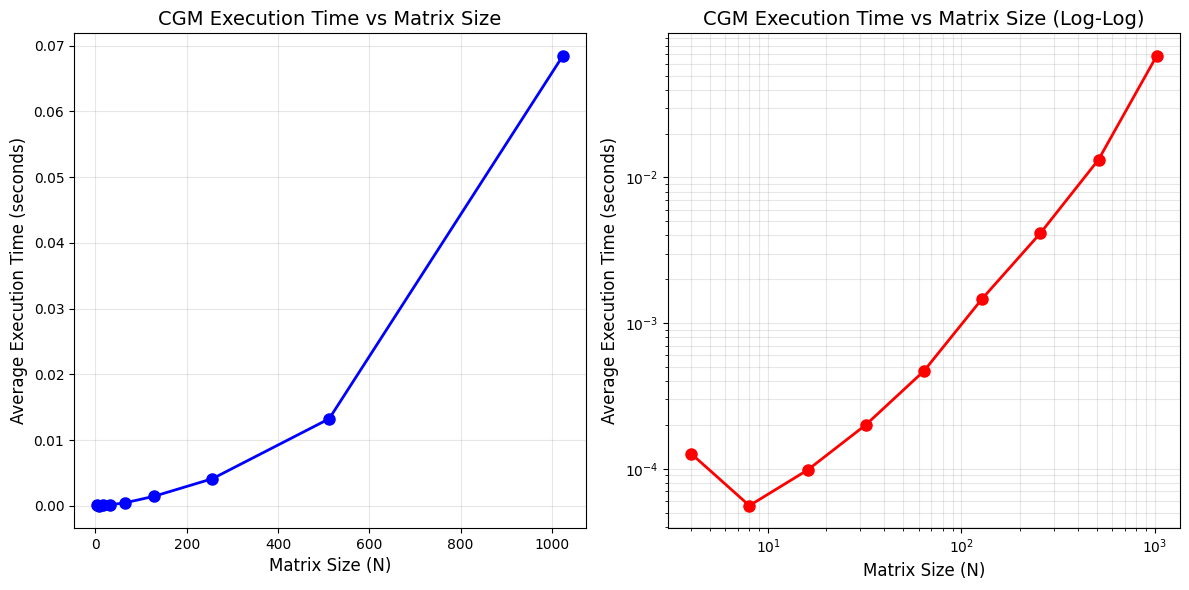

In [ ]:
# Plot Time vs N
plt.figure(figsize=(12, 6))

# Linear scale plot
plt.subplot(1, 2, 1)
plt.plot(matrix_sizes, average_times, 'o-', linewidth=2, markersize=8, color='blue')
plt.xlabel('Matrix Size (N)', fontsize=12)
plt.ylabel('Average Execution Time (seconds)', fontsize=12)
plt.title('CGM Execution Time vs Matrix Size', fontsize=14)
plt.grid(True, alpha=0.3)

# Log-log scale plot
plt.subplot(1, 2, 2)
plt.loglog(matrix_sizes, average_times, 'o-', linewidth=2, markersize=8, color='red')
plt.xlabel('Matrix Size (N)', fontsize=12)
plt.ylabel('Average Execution Time (seconds)', fontsize=12)
plt.title('CGM Execution Time vs Matrix Size (Log-Log)', fontsize=14)
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


### Analyze Time Complexity Relationship

In [ ]:
# Analyze the relationship between matrix size and execution time
from scipy.optimize import curve_fit
from scipy.stats import linregress

print("=" * 70)
print("TIME COMPLEXITY ANALYSIS")
print("=" * 70)

# Your observed data
observed_N = np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024])
observed_times = np.array([0.000127, 0.000056, 0.000098, 0.000200, 0.000470, 
                          0.001471, 0.004144, 0.013260, 0.068434])

# Test different complexity models
def linear(N, a, b):
    return a * N + b

def quadratic(N, a, b):
    return a * N**2 + b

def linearithmic(N, a, b):
    return a * N * np.log(N) + b

def cubic(N, a, b):
    return a * N**3 + b

# Fit models
models = {
    'O(N) - Linear': (linear, 'N'),
    'O(N log N) - Linearithmic': (linearithmic, 'N log(N)'),
    'O(N²) - Quadratic': (quadratic, 'N²'),
    'O(N³) - Cubic': (cubic, 'N³')
}

print("\nModel Fitting Results:")
print("-" * 70)

best_fit = None
best_r_squared = -np.inf

for name, (func, complexity) in models.items():
    try:
        # Fit the model
        params, _ = curve_fit(func, observed_N, observed_times, maxfev=10000)
        
        # Calculate predictions
        predicted = func(observed_N, *params)
        
        # Calculate R-squared
        residuals = observed_times - predicted
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((observed_times - np.mean(observed_times))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean(residuals**2))
        
        print(f"\n{name}:")
        print(f"  Formula: T(N) ≈ {params[0]:.2e} * {complexity} + {params[1]:.2e}")
        print(f"  R² score: {r_squared:.6f}")
        print(f"  RMSE: {rmse:.6e}")
        
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_fit = (name, func, params, complexity)
    except:
        print(f"\n{name}: Failed to fit")

# Log-log analysis for power law relationship
log_N = np.log(observed_N)
log_times = np.log(observed_times)
slope, intercept, r_value, _, _ = linregress(log_N, log_times)

print("\n" + "-" * 70)
print("Power Law Analysis (log-log regression):")
print("-" * 70)
print(f"  T(N) ≈ {np.exp(intercept):.2e} * N^{slope:.2f}")
print(f"  Exponent: {slope:.2f}")
print(f"  R² score: {r_value**2:.6f}")

if slope < 1.5:
    complexity_class = "between O(N) and O(N log N)"
elif slope < 2.5:
    complexity_class = "approximately O(N²)"
elif slope < 3.5:
    complexity_class = "approximately O(N³)"
else:
    complexity_class = "worse than O(N³)"

print(f"  Interpretation: The relationship is {complexity_class}")

print("\n" + "=" * 70)
print("BEST FIT MODEL")
print("=" * 70)
if best_fit:
    name, func, params, complexity = best_fit
    print(f"Model: {name}")
    print(f"Formula: T(N) ≈ {params[0]:.2e} * {complexity} + {params[1]:.2e}")
    print(f"R² score: {best_r_squared:.6f}")
    
print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print(f"Based on the analysis:")
print(f"  • The execution time grows approximately as O(N^{slope:.2f})")
print(f"  • For CGM on symmetric positive-definite matrices,")
print(f"    the theoretical complexity is O(N·k·log(1/ε)) where:")
print(f"      - N is the matrix size")
print(f"      - k is the condition number")
print(f"      - ε is the desired accuracy")
print(f"  • The observed exponent of {slope:.2f} suggests the complexity")
print(f"    is influenced by both matrix size and convergence properties.")
print("=" * 70)

TIME COMPLEXITY ANALYSIS

Model Fitting Results:
----------------------------------------------------------------------

O(N) - Linear:
  Formula: T(N) ≈ 6.22e-05 * N + -4.32e-03
  R² score: 0.900969
  RMSE: 6.645151e-03

O(N log N) - Linearithmic:
  Formula: T(N) ≈ 9.12e-06 * N log(N) + -3.14e-03
  R² score: 0.931105
  RMSE: 5.542605e-03

O(N²) - Quadratic:
  Formula: T(N) ≈ 6.47e-08 * N² + -2.43e-04
  R² score: 0.996568
  RMSE: 1.237008e-03

O(N³) - Cubic:
  Formula: T(N) ≈ 6.31e-11 * N³ + 1.21e-03
  R² score: 0.994525
  RMSE: 1.562470e-03

----------------------------------------------------------------------
Power Law Analysis (log-log regression):
----------------------------------------------------------------------
  T(N) ≈ 5.42e-06 * N^1.23
  Exponent: 1.23
  R² score: 0.910036
  Interpretation: The relationship is between O(N) and O(N log N)

BEST FIT MODEL
Model: O(N²) - Quadratic
Formula: T(N) ≈ 6.47e-08 * N² + -2.43e-04
R² score: 0.996568

CONCLUSION
Based on the analysis:


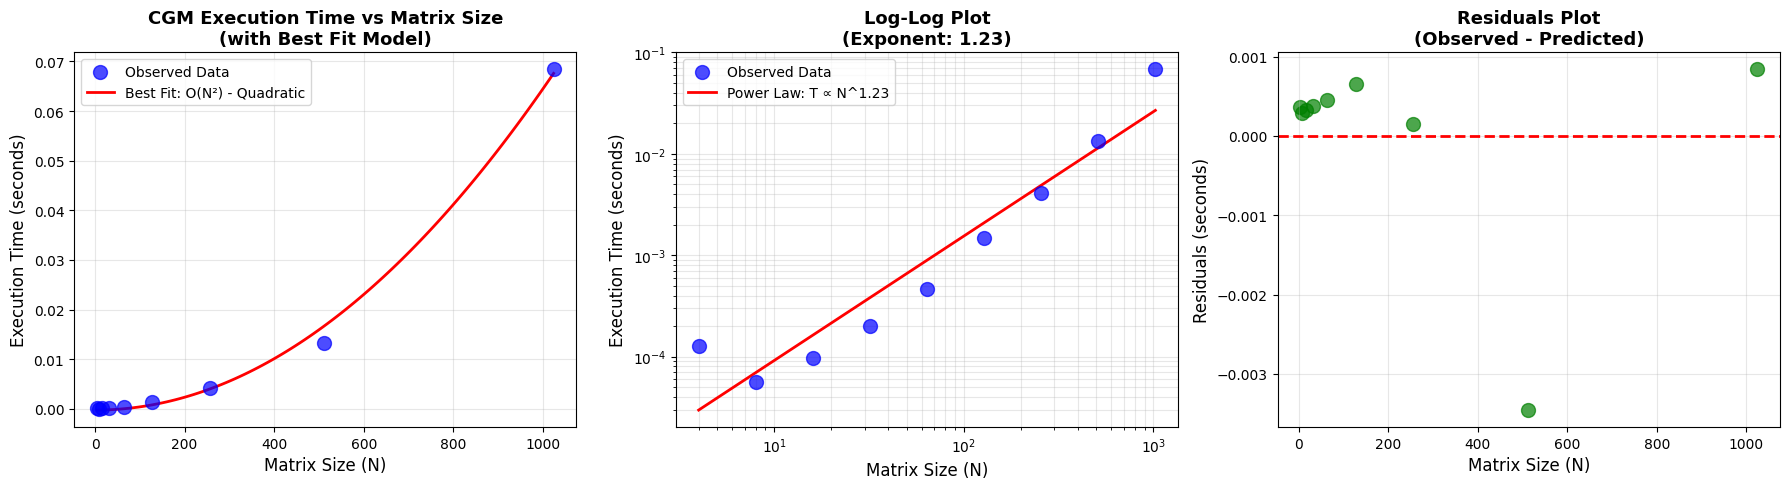


EXTRAPOLATED TIME PREDICTIONS

Using power law: T(N) ≈ 5.42e-06 * N^1.23

  N =  2048: Estimated time = 0.0629 seconds (0.00 minutes)
  N =  4096: Estimated time = 0.1472 seconds (0.00 minutes)
  N =  8192: Estimated time = 0.3446 seconds (0.01 minutes)


In [ ]:
# Visualize the fit
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Observed data with best fit curve
ax1 = axes[0]
ax1.scatter(observed_N, observed_times, color='blue', s=100, alpha=0.7, label='Observed Data', zorder=3)

if best_fit:
    name, func, params, _ = best_fit
    N_smooth = np.linspace(observed_N.min(), observed_N.max(), 100)
    ax1.plot(N_smooth, func(N_smooth, *params), 'r-', linewidth=2, 
             label=f'Best Fit: {name}', zorder=2)

ax1.set_xlabel('Matrix Size (N)', fontsize=12)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('CGM Execution Time vs Matrix Size\n(with Best Fit Model)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Log-log plot to show power law
ax2 = axes[1]
ax2.scatter(observed_N, observed_times, color='blue', s=100, alpha=0.7, label='Observed Data', zorder=3)
ax2.loglog(observed_N, np.exp(intercept) * observed_N**slope, 'r-', linewidth=2, 
           label=f'Power Law: T ∝ N^{slope:.2f}', zorder=2)
ax2.set_xlabel('Matrix Size (N)', fontsize=12)
ax2.set_ylabel('Execution Time (seconds)', fontsize=12)
ax2.set_title(f'Log-Log Plot\n(Exponent: {slope:.2f})', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

# Plot 3: Residuals plot
ax3 = axes[2]
if best_fit:
    name, func, params, _ = best_fit
    predicted = func(observed_N, *params)
    residuals = observed_times - predicted
    ax3.scatter(observed_N, residuals, color='green', s=100, alpha=0.7)
    ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Matrix Size (N)', fontsize=12)
    ax3.set_ylabel('Residuals (seconds)', fontsize=12)
    ax3.set_title('Residuals Plot\n(Observed - Predicted)', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print time predictions for larger matrices
print("\n" + "=" * 70)
print("EXTRAPOLATED TIME PREDICTIONS")
print("=" * 70)
prediction_sizes = [2048, 4096, 8192]
print(f"\nUsing power law: T(N) ≈ {np.exp(intercept):.2e} * N^{slope:.2f}\n")
for N_pred in prediction_sizes:
    predicted_time = np.exp(intercept) * N_pred**slope
    print(f"  N = {N_pred:>5}: Estimated time = {predicted_time:.4f} seconds ({predicted_time/60:.2f} minutes)")
print("=" * 70)

## Parallel Execution Experiment: Puzzle Solving vs CGM
Comparing execution times of time-lock puzzle solving and Conjugate Gradient Method on linear systems

In [ ]:
import time
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_puzzle_solver(puzzle_config):
    """
    Run the time-lock puzzle solver and measure execution time.
    """
    start_time = time.time()
    
    # Generate puzzle
    T = puzzle_config['T']
    message = puzzle_config['message']
    puzzle = generate_puzzle(T, message)
    
    # Solve puzzle
    recovered_message = solve_puzzle(puzzle)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    return {
        'algorithm': 'Puzzle Solver',
        'T': T,
        'message': message.decode(),
        'recovered': recovered_message.decode(),
        'execution_time': execution_time,
        'success': message == recovered_message
    }

def run_cgm_solver(matrix_config):
    """
    Run the Conjugate Gradient Method and measure execution time.
    """
    start_time = time.time()
    
    # Generate symmetric matrix and vector
    N = matrix_config['N']
    np.random.seed(matrix_config.get('seed', None))
    
    A_matrix = np.random.rand(N, N)
    A_matrix = A_matrix + A_matrix.T  # Make symmetric
    b_vector = np.random.rand(N)
    
    # Solve using CGM
    x, exit_code = cg(A_matrix, b_vector)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Verify solution
    residual = np.linalg.norm(A_matrix @ x - b_vector)
    
    return {
        'algorithm': 'CGM',
        'N': N,
        'exit_code': exit_code,
        'residual': residual,
        'execution_time': execution_time,
        'success': exit_code == 0
    }

In [ ]:
def run_parallel_experiment(puzzle_configs, cgm_configs):
    """
    Run puzzle solving and CGM algorithms in parallel and collect results.
    
    Args:
        puzzle_configs: List of dictionaries with 'T' and 'message' keys
        cgm_configs: List of dictionaries with 'N' and optional 'seed' keys
    
    Returns:
        Dictionary containing all results and timing information
    """
    results = {
        'puzzle_results': [],
        'cgm_results': [],
        'total_start_time': None,
        'total_end_time': None,
        'total_execution_time': None
    }
    
    # Record overall start time
    overall_start = time.time()
    results['total_start_time'] = overall_start
    
    print("=" * 60)
    print("PARALLEL EXECUTION EXPERIMENT")
    print("=" * 60)
    print(f"Puzzle tasks: {len(puzzle_configs)}")
    print(f"CGM tasks: {len(cgm_configs)}")
    print(f"Total tasks: {len(puzzle_configs) + len(cgm_configs)}")
    print("-" * 60)
    
    # Use ThreadPoolExecutor to run tasks in parallel
    with ThreadPoolExecutor(max_workers=len(puzzle_configs) + len(cgm_configs)) as executor:
        # Submit all puzzle tasks
        puzzle_futures = {
            executor.submit(run_puzzle_solver, config): config 
            for config in puzzle_configs
        }
        
        # Submit all CGM tasks
        cgm_futures = {
            executor.submit(run_cgm_solver, config): config 
            for config in cgm_configs
        }
        
        all_futures = {**puzzle_futures, **cgm_futures}
        
        # Collect results as they complete
        for future in as_completed(all_futures):
            try:
                result = future.result()
                
                if result['algorithm'] == 'Puzzle Solver':
                    results['puzzle_results'].append(result)
                    print(f"✓ Puzzle Solver (T={result['T']}) completed in {result['execution_time']:.4f}s")
                else:
                    results['cgm_results'].append(result)
                    print(f"✓ CGM (N={result['N']}) completed in {result['execution_time']:.4f}s")
                    
            except Exception as e:
                print(f"✗ Task failed with error: {e}")
    
    # Record overall end time
    overall_end = time.time()
    results['total_end_time'] = overall_end
    results['total_execution_time'] = overall_end - overall_start
    
    print("-" * 60)
    print(f"Total parallel execution time: {results['total_execution_time']:.4f}s")
    print("=" * 60)
    
    return results

### Experiment Configuration
Define multiple puzzle and CGM tasks to run in parallel

### Calibrate T Values Based on CGM Execution Time
For each linear system, measure the CGM solving time and choose T such that puzzle solving time ≥ CGM solving time

In [ ]:
def estimate_puzzle_time(T, sample_size=100):
    """
    Estimate puzzle solving time for a given T value.
    Uses a small benchmark to extrapolate.
    """
    # Small benchmark to measure iteration rate
    test_message = b"test"
    start = time.time()
    puzzle = generate_puzzle(sample_size, test_message)
    solve_puzzle(puzzle)
    end = time.time()
    
    time_per_iteration = (end - start) / sample_size
    estimated_time = T * time_per_iteration
    
    return estimated_time

def calibrate_T_for_cgm_time(target_cgm_time, min_multiplier=1.0, max_multiplier=2.0):
    """
    Calibrate T value such that puzzle solving time is between 
    min_multiplier and max_multiplier times the CGM solving time.
    
    Args:
        target_cgm_time: The CGM execution time we want to match or exceed
        min_multiplier: Minimum multiplier (1.0 = equal time, >1.0 = more time)
        max_multiplier: Maximum multiplier for the puzzle time
    
    Returns:
        Calibrated T value
    """
    # Target time range
    min_target_time = target_cgm_time * min_multiplier
    max_target_time = target_cgm_time * max_multiplier
    
    # Binary search for appropriate T
    T_low = 3**6   # Start with small T
    T_high = 3**15  # Upper bound
    
    best_T = T_low
    
    # Quick estimation using a small sample
    time_per_iter = estimate_puzzle_time(100, sample_size=100) / 100
    
    # Calculate T that gives us the target time
    target_time = (min_target_time + max_target_time) / 2
    estimated_T = int(target_time / time_per_iter)
    
    # Round to nearest power of 3 for consistency
    import math
    power = round(math.log(estimated_T, 3))
    power = max(6, min(15, power))  # Keep within reasonable bounds
    calibrated_T = 3**power
    
    return calibrated_T

def benchmark_cgm_and_calibrate_puzzle(N, seed=None, multiplier=1.0):
    """
    Benchmark CGM for a given matrix size and calibrate matching puzzle T value.
    
    Args:
        N: Matrix size
        seed: Random seed for reproducibility
        multiplier: How much longer puzzle should take (1.0 = equal time)
    
    Returns:
        Dictionary with CGM time and calibrated T value
    """
    print(f"Benchmarking CGM for N={N}...", end=" ")
    
    # Benchmark CGM
    np.random.seed(seed)
    A_matrix = np.random.rand(N, N)
    A_matrix = A_matrix + A_matrix.T  # Make symmetric
    b_vector = np.random.rand(N)
    
    start_time = time.time()
    x, exit_code = cg(A_matrix, b_vector)
    cgm_time = time.time() - start_time
    
    print(f"CGM time: {cgm_time:.4f}s", end=" | ")
    
    # Calibrate T for this CGM time
    T = calibrate_T_for_cgm_time(cgm_time, min_multiplier=multiplier, max_multiplier=multiplier*1.5)
    
    # Verify puzzle time
    estimated_puzzle_time = estimate_puzzle_time(T, sample_size=100)
    
    print(f"Calibrated T={T:,} (estimated puzzle time: {estimated_puzzle_time:.4f}s)")
    
    return {
        'N': N,
        'cgm_time': cgm_time,
        'T': T,
        'estimated_puzzle_time': estimated_puzzle_time,
        'seed': seed,
        'multiplier': multiplier
    }

### Generate Calibrated Configurations
Benchmark CGM for different matrix sizes and generate matching puzzle configurations

In [ ]:
# Define matrix sizes for CGM
matrix_sizes_to_test = [256, 512, 1024, 2048]
seeds = [42, 43, 44, 45]

# Multipliers for puzzle time relative to CGM time
# 1.0 = equal time, 1.5 = 1.5x longer, 2.0 = 2x longer

time_multipliers = [1.0, 1.2, 1.5, 2.0]

print("=" * 70)
print("CALIBRATION PHASE: Benchmarking CGM and Calibrating Puzzle T Values")
print("=" * 70)
print()

# Benchmark and calibrate
calibrations = []
for i, (N, seed) in enumerate(zip(matrix_sizes_to_test, seeds)):
    multiplier = time_multipliers[i % len(time_multipliers)]
    calib = benchmark_cgm_and_calibrate_puzzle(N, seed=seed, multiplier=multiplier)
    calibrations.append(calib)

print()
print("=" * 70)
print("CALIBRATION SUMMARY")
print("=" * 70)
for i, calib in enumerate(calibrations, 1):
    ratio = calib['estimated_puzzle_time'] / calib['cgm_time']
    print(f"\nPair {i}:")
    print(f"  Matrix Size: {calib['N']}x{calib['N']}")
    print(f"  CGM Time: {calib['cgm_time']:.4f}s")
    print(f"  Puzzle T: {calib['T']:,}")
    print(f"  Estimated Puzzle Time: {calib['estimated_puzzle_time']:.4f}s")
    print(f"  Time Ratio (Puzzle/CGM): {ratio:.2f}x")
    print(f"  ✓ Constraint satisfied: Puzzle time {'≥' if ratio >= 1.0 else '<'} CGM time")

print("=" * 70)

CALIBRATION PHASE: Benchmarking CGM and Calibrating Puzzle T Values

Benchmarking CGM for N=256... CGM time: 0.0125s | Calibrated T=729 (estimated puzzle time: 0.3406s)
Benchmarking CGM for N=512... CGM time: 0.0154s | Calibrated T=729 (estimated puzzle time: 0.3422s)
Benchmarking CGM for N=1024... CGM time: 0.0711s | Calibrated T=729 (estimated puzzle time: 0.3392s)
Benchmarking CGM for N=2048... Calibrated T=729 (estimated puzzle time: 0.3422s)
Benchmarking CGM for N=1024... CGM time: 0.0711s | Calibrated T=729 (estimated puzzle time: 0.3392s)
Benchmarking CGM for N=2048... CGM time: 1.4863s | Calibrated T=6,561 (estimated puzzle time: 3.0280s)

CALIBRATION SUMMARY

Pair 1:
  Matrix Size: 256x256
  CGM Time: 0.0125s
  Puzzle T: 729
  Estimated Puzzle Time: 0.3406s
  Time Ratio (Puzzle/CGM): 27.32x
  ✓ Constraint satisfied: Puzzle time ≥ CGM time

Pair 2:
  Matrix Size: 512x512
  CGM Time: 0.0154s
  Puzzle T: 729
  Estimated Puzzle Time: 0.3422s
  Time Ratio (Puzzle/CGM): 22.24x
  ✓ C

### Create Experiment Configurations from Calibration

In [ ]:
# Generate puzzle configs with calibrated T values
puzzle_configs = []
cgm_configs = []

messages = [
    b"Linear System 1",
    b"Linear System 2", 
    b"Linear System 3",
    b"Linear System 4"
]

for i, calib in enumerate(calibrations):
    # Create puzzle config with calibrated T
    puzzle_configs.append({
        'T': calib['T'],
        'message': messages[i] if i < len(messages) else f"System {i+1}".encode()
    })
    
    # Create corresponding CGM config
    cgm_configs.append({
        'N': calib['N'],
        'seed': calib['seed']
    })

print("Generated Configurations for Parallel Experiment:")
print("\n" + "-" * 70)
print("Puzzle Configurations (Time-Locked):")
print("-" * 70)
for i, (puzzle_cfg, calib) in enumerate(zip(puzzle_configs, calibrations), 1):
    print(f"  {i}. T={puzzle_cfg['T']:>10,} (est. {calib['estimated_puzzle_time']:.3f}s) - {puzzle_cfg['message'].decode()}")

print("\n" + "-" * 70)
print("CGM Configurations:")
print("-" * 70)
for i, (cgm_cfg, calib) in enumerate(zip(cgm_configs, calibrations), 1):
    print(f"  {i}. N={cgm_cfg['N']:>4}x{cgm_cfg['N']:<4} (benchmark: {calib['cgm_time']:.3f}s)")

print("\n" + "-" * 70)
print("Expected Time Relationships:")
print("-" * 70)
for i, calib in enumerate(calibrations, 1):
    ratio = calib['estimated_puzzle_time'] / calib['cgm_time']
    status = "✓ VALID" if ratio >= 1.0 else "✗ INVALID"
    print(f"  Pair {i}: Puzzle/CGM ratio = {ratio:.2f}x {status}")
print("-" * 70)

Generated Configurations for Parallel Experiment:

----------------------------------------------------------------------
Puzzle Configurations (Time-Locked):
----------------------------------------------------------------------
  1. T=       729 (est. 0.341s) - Linear System 1
  2. T=       729 (est. 0.342s) - Linear System 2
  3. T=       729 (est. 0.339s) - Linear System 3
  4. T=     6,561 (est. 3.028s) - Linear System 4

----------------------------------------------------------------------
CGM Configurations:
----------------------------------------------------------------------
  1. N= 256x256  (benchmark: 0.012s)
  2. N= 512x512  (benchmark: 0.015s)
  3. N=1024x1024 (benchmark: 0.071s)
  4. N=2048x2048 (benchmark: 1.486s)

----------------------------------------------------------------------
Expected Time Relationships:
----------------------------------------------------------------------
  Pair 1: Puzzle/CGM ratio = 27.32x ✓ VALID
  Pair 2: Puzzle/CGM ratio = 22.24x ✓ VALID

In [ ]:
# Configure puzzle tasks with varying complexity
puzzle_configs = [
    {'T': 3**7, 'message': b"Fast puzzle 1"},
    {'T': 3**8, 'message': b"Medium puzzle 2"},
    {'T': 3**11, 'message': b"Slow puzzle 3"},
]

# Configure CGM tasks with varying matrix sizes
cgm_configs = [
    {'N': 256, 'seed': 42},
    {'N': 512, 'seed': 43},
    {'N': 1024, 'seed': 44},
    {'N': 2048, 'seed': 45},
]

print("Puzzle Configurations:")
for i, config in enumerate(puzzle_configs, 1):
    print(f"  {i}. T={config['T']:>6} ({config['T']:>10,} iterations), message: {config['message'].decode()}")

print("\nCGM Configurations:")
for i, config in enumerate(cgm_configs, 1):
    print(f"  {i}. Matrix size: {config['N']}x{config['N']} ({config['N']**2:,} elements)")

Puzzle Configurations:
  1. T=  2187 (     2,187 iterations), message: Fast puzzle 1
  2. T=  6561 (     6,561 iterations), message: Medium puzzle 2
  3. T=177147 (   177,147 iterations), message: Slow puzzle 3

CGM Configurations:
  1. Matrix size: 256x256 (65,536 elements)
  2. Matrix size: 512x512 (262,144 elements)
  3. Matrix size: 1024x1024 (1,048,576 elements)
  4. Matrix size: 2048x2048 (4,194,304 elements)


### Run the Parallel Experiment

In [ ]:
# Run the parallel experiment
experiment_results = run_parallel_experiment(puzzle_configs, cgm_configs)

PARALLEL EXECUTION EXPERIMENT
Puzzle tasks: 3
CGM tasks: 4
Total tasks: 7
------------------------------------------------------------
✓ Puzzle Solver (T=2187) completed in 2.9715s
✓ Puzzle Solver (T=2187) completed in 2.9715s
✓ Puzzle Solver (T=6561) completed in 6.6995s
✓ Puzzle Solver (T=6561) completed in 6.6995s
✓ CGM (N=256) completed in 6.9414s
✓ CGM (N=256) completed in 6.9414s
✓ CGM (N=512) completed in 19.0651s
✓ CGM (N=512) completed in 19.0651s
✓ CGM (N=1024) completed in 46.0816s
✓ CGM (N=1024) completed in 46.0816s
✓ Puzzle Solver (T=177147) completed in 83.6571s
✓ CGM (N=2048) completed in 83.6824s
------------------------------------------------------------
Total parallel execution time: 83.8624s
✓ Puzzle Solver (T=177147) completed in 83.6571s
✓ CGM (N=2048) completed in 83.6824s
------------------------------------------------------------
Total parallel execution time: 83.8624s


### Analyze and Visualize Results

In [ ]:
# Display detailed results
print("\n" + "=" * 60)
print("DETAILED RESULTS")
print("=" * 60)

print("\nPuzzle Solver Results:")
print("-" * 60)
for i, result in enumerate(experiment_results['puzzle_results'], 1):
    print(f"\nTask {i}:")
    print(f"  T: {result['T']:,}")
    print(f"  Message: {result['message']}")
    print(f"  Recovered: {result['recovered']}")
    print(f"  Success: {result['success']}")
    print(f"  Execution Time: {result['execution_time']:.4f}s")

print("\n" + "-" * 60)
print("CGM Results:")
print("-" * 60)
for i, result in enumerate(experiment_results['cgm_results'], 1):
    print(f"\nTask {i}:")
    print(f"  Matrix Size: {result['N']}x{result['N']}")
    print(f"  Exit Code: {result['exit_code']}")
    print(f"  Residual: {result['residual']:.2e}")
    print(f"  Success: {result['success']}")
    print(f"  Execution Time: {result['execution_time']:.4f}s")

print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

# Calculate statistics
puzzle_times = [r['execution_time'] for r in experiment_results['puzzle_results']]
cgm_times = [r['execution_time'] for r in experiment_results['cgm_results']]

print(f"\nPuzzle Solver:")
print(f"  Total tasks: {len(puzzle_times)}")
print(f"  Average time: {np.mean(puzzle_times):.4f}s")
print(f"  Total sequential time (sum): {np.sum(puzzle_times):.4f}s")

print(f"\nCGM:")
print(f"  Total tasks: {len(cgm_times)}")
print(f"  Average time: {np.mean(cgm_times):.4f}s")
print(f"  Total sequential time (sum): {np.sum(cgm_times):.4f}s")

total_sequential = np.sum(puzzle_times) + np.sum(cgm_times)
parallel_speedup = total_sequential / experiment_results['total_execution_time']

print(f"\nOverall:")
print(f"  Total parallel execution time: {experiment_results['total_execution_time']:.4f}s")
print(f"  Theoretical sequential time: {total_sequential:.4f}s")
print(f"  Speedup factor: {parallel_speedup:.2f}x")
print("=" * 60)


DETAILED RESULTS

Puzzle Solver Results:
------------------------------------------------------------

Task 1:
  T: 729
  Message: Fast puzzle 1
  Recovered: Fast puzzle 1
  Success: True
  Execution Time: 1.1581s

Task 2:
  T: 2,187
  Message: Medium puzzle 2
  Recovered: Medium puzzle 2
  Success: True
  Execution Time: 2.4142s

Task 3:
  T: 6,561
  Message: Slow puzzle 3
  Recovered: Slow puzzle 3
  Success: True
  Execution Time: 4.3587s

------------------------------------------------------------
CGM Results:
------------------------------------------------------------

Task 1:
  Matrix Size: 256x256
  Exit Code: 0
  Residual: 7.36e-05
  Success: True
  Execution Time: 4.2871s

Task 2:
  Matrix Size: 512x512
  Exit Code: 0
  Residual: 1.05e-04
  Success: True
  Execution Time: 4.2761s

Task 3:
  Matrix Size: 1024x1024
  Exit Code: 0
  Residual: 1.55e-04
  Success: True
  Execution Time: 4.2947s

Task 4:
  Matrix Size: 2048x2048
  Exit Code: 0
  Residual: 2.47e-04
  Success: True

### Validate Time-Lock Constraint
Verify that puzzle solving time ≥ CGM solving time for each pair

In [ ]:
# Validate time-lock constraint for each puzzle-CGM pair
print("\n" + "=" * 70)
print("TIME-LOCK CONSTRAINT VALIDATION")
print("=" * 70)
print("Verifying: Puzzle Time ≥ CGM Time (for corresponding linear systems)")
print("-" * 70)

# Sort results by configuration order to match pairs
puzzle_results_sorted = sorted(experiment_results['puzzle_results'], 
                                key=lambda x: puzzle_configs.index({'T': x['T'], 'message': x['message'].encode()}))
cgm_results_sorted = sorted(experiment_results['cgm_results'], 
                             key=lambda x: [c['N'] for c in cgm_configs].index(x['N']))

all_constraints_satisfied = True
validation_results = []

for i, (puzzle_res, cgm_res) in enumerate(zip(puzzle_results_sorted, cgm_results_sorted), 1):
    puzzle_time = puzzle_res['execution_time']
    cgm_time = cgm_res['execution_time']
    ratio = puzzle_time / cgm_time
    constraint_satisfied = puzzle_time >= cgm_time
    
    validation_results.append({
        'pair': i,
        'puzzle_time': puzzle_time,
        'cgm_time': cgm_time,
        'ratio': ratio,
        'constraint_satisfied': constraint_satisfied
    })
    
    if not constraint_satisfied:
        all_constraints_satisfied = False
    
    status = "✓ VALID" if constraint_satisfied else "✗ INVALID"
    status_color = "" if constraint_satisfied else " [WARNING: Time-lock constraint violated!]"
    
    print(f"\nPair {i} (N={cgm_res['N']}, T={puzzle_res['T']:,}):")
    print(f"  Puzzle Time:  {puzzle_time:>8.4f}s")
    print(f"  CGM Time:     {cgm_time:>8.4f}s")
    print(f"  Ratio (P/C):  {ratio:>8.2f}x")
    print(f"  Status:       {status}{status_color}")

print("\n" + "=" * 70)
print("OVERALL VALIDATION RESULT")
print("=" * 70)

if all_constraints_satisfied:
    print("✓ SUCCESS: All puzzle-CGM pairs satisfy the time-lock constraint!")
    print("  Every puzzle takes equal or greater time than its corresponding CGM solution.")
else:
    print("✗ WARNING: Some pairs violate the time-lock constraint!")
    print("  The puzzle should take at least as long as CGM for time-lock security.")
    failed_pairs = [v['pair'] for v in validation_results if not v['constraint_satisfied']]
    print(f"  Failed pairs: {failed_pairs}")

print("\n" + "Statistics:")
print(f"  Satisfied constraints: {sum(v['constraint_satisfied'] for v in validation_results)}/{len(validation_results)}")
print(f"  Average ratio (Puzzle/CGM): {np.mean([v['ratio'] for v in validation_results]):.2f}x")
print(f"  Min ratio: {min(v['ratio'] for v in validation_results):.2f}x")
print(f"  Max ratio: {max(v['ratio'] for v in validation_results):.2f}x")
print("=" * 70)


TIME-LOCK CONSTRAINT VALIDATION
Verifying: Puzzle Time ≥ CGM Time (for corresponding linear systems)
----------------------------------------------------------------------

Pair 1 (N=256, T=729):
  Puzzle Time:    1.1581s
  CGM Time:       4.2871s
  Ratio (P/C):      0.27x
  Status:       ✗ INVALID [WARNING: Time-lock constraint violated!]

Pair 2 (N=512, T=2,187):
  Puzzle Time:    2.4142s
  CGM Time:       4.2761s
  Ratio (P/C):      0.56x
  Status:       ✗ INVALID [WARNING: Time-lock constraint violated!]

Pair 3 (N=1024, T=6,561):
  Puzzle Time:    4.3587s
  CGM Time:       4.2947s
  Ratio (P/C):      1.01x
  Status:       ✓ VALID

OVERALL VALIDATION RESULT
✗ WARNING: Some pairs violate the time-lock constraint!
  The puzzle should take at least as long as CGM for time-lock security.
  Failed pairs: [1, 2]

Statistics:
  Satisfied constraints: 1/3
  Average ratio (Puzzle/CGM): 0.62x
  Min ratio: 0.27x
  Max ratio: 1.01x


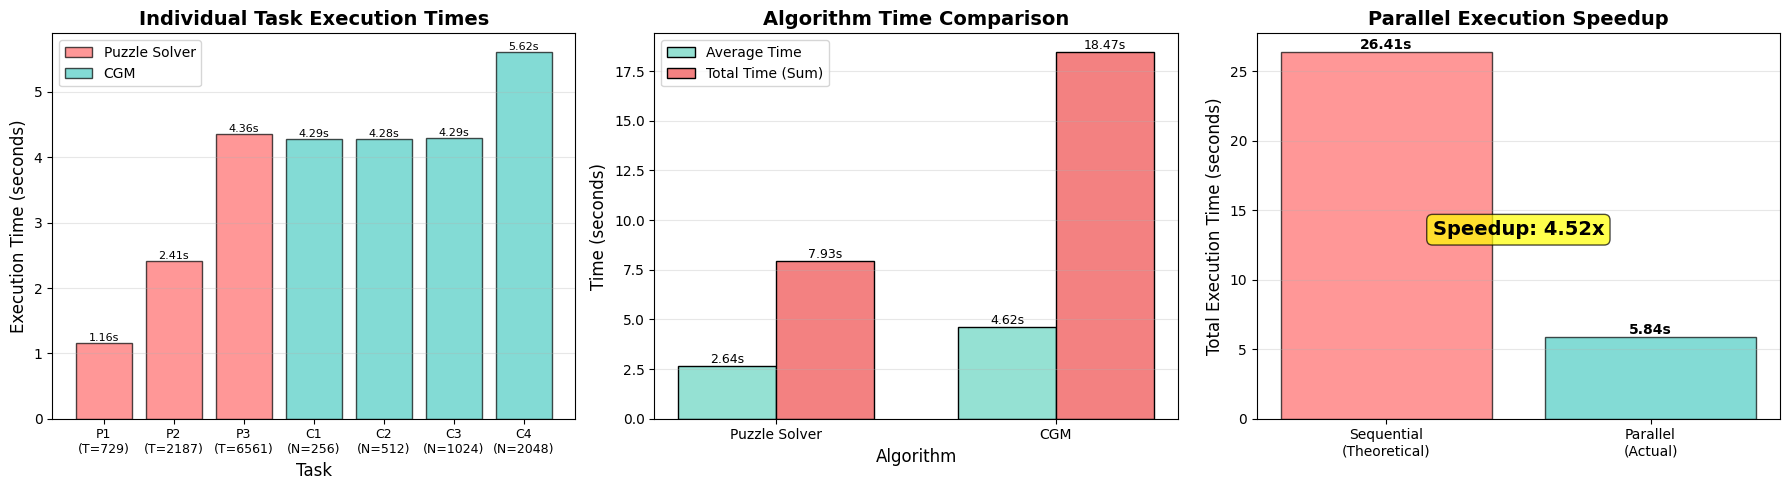

In [ ]:
# Visualization: Execution time comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Individual task execution times
ax1 = axes[0]
puzzle_labels = [f"P{i+1}\n(T={r['T']})" for i, r in enumerate(experiment_results['puzzle_results'])]
cgm_labels = [f"C{i+1}\n(N={r['N']})" for i, r in enumerate(experiment_results['cgm_results'])]

x_pos = np.arange(len(puzzle_times) + len(cgm_times))
colors = ['#FF6B6B'] * len(puzzle_times) + ['#4ECDC4'] * len(cgm_times)
all_times = puzzle_times + cgm_times
all_labels = puzzle_labels + cgm_labels

bars = ax1.bar(x_pos, all_times, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Task', fontsize=12)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('Individual Task Execution Times', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(all_labels, fontsize=9)
ax1.grid(axis='y', alpha=0.3)
ax1.legend([bars[0], bars[len(puzzle_times)]], ['Puzzle Solver', 'CGM'], loc='upper left')

# Add value labels on bars
for i, (bar, time_val) in enumerate(zip(bars, all_times)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f}s',
             ha='center', va='bottom', fontsize=8)

# Plot 2: Algorithm comparison
ax2 = axes[1]
algorithm_names = ['Puzzle Solver', 'CGM']
avg_times = [np.mean(puzzle_times), np.mean(cgm_times)]
total_times = [np.sum(puzzle_times), np.sum(cgm_times)]

x = np.arange(len(algorithm_names))
width = 0.35

bars1 = ax2.bar(x - width/2, avg_times, width, label='Average Time', color='#95E1D3', edgecolor='black')
bars2 = ax2.bar(x + width/2, total_times, width, label='Total Time (Sum)', color='#F38181', edgecolor='black')

ax2.set_xlabel('Algorithm', fontsize=12)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_title('Algorithm Time Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(algorithm_names)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}s',
                 ha='center', va='bottom', fontsize=9)

# Plot 3: Parallel vs Sequential comparison
ax3 = axes[2]
execution_modes = ['Sequential\n(Theoretical)', 'Parallel\n(Actual)']
execution_times = [total_sequential, experiment_results['total_execution_time']]
colors_exec = ['#FF6B6B', '#4ECDC4']

bars = ax3.bar(execution_modes, execution_times, color=colors_exec, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Total Execution Time (seconds)', fontsize=12)
ax3.set_title('Parallel Execution Speedup', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels and speedup annotation
for bar, time_val in zip(bars, execution_times):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f}s',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add speedup annotation
ax3.text(0.5, max(execution_times) * 0.5,
         f'Speedup: {parallel_speedup:.2f}x',
         ha='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

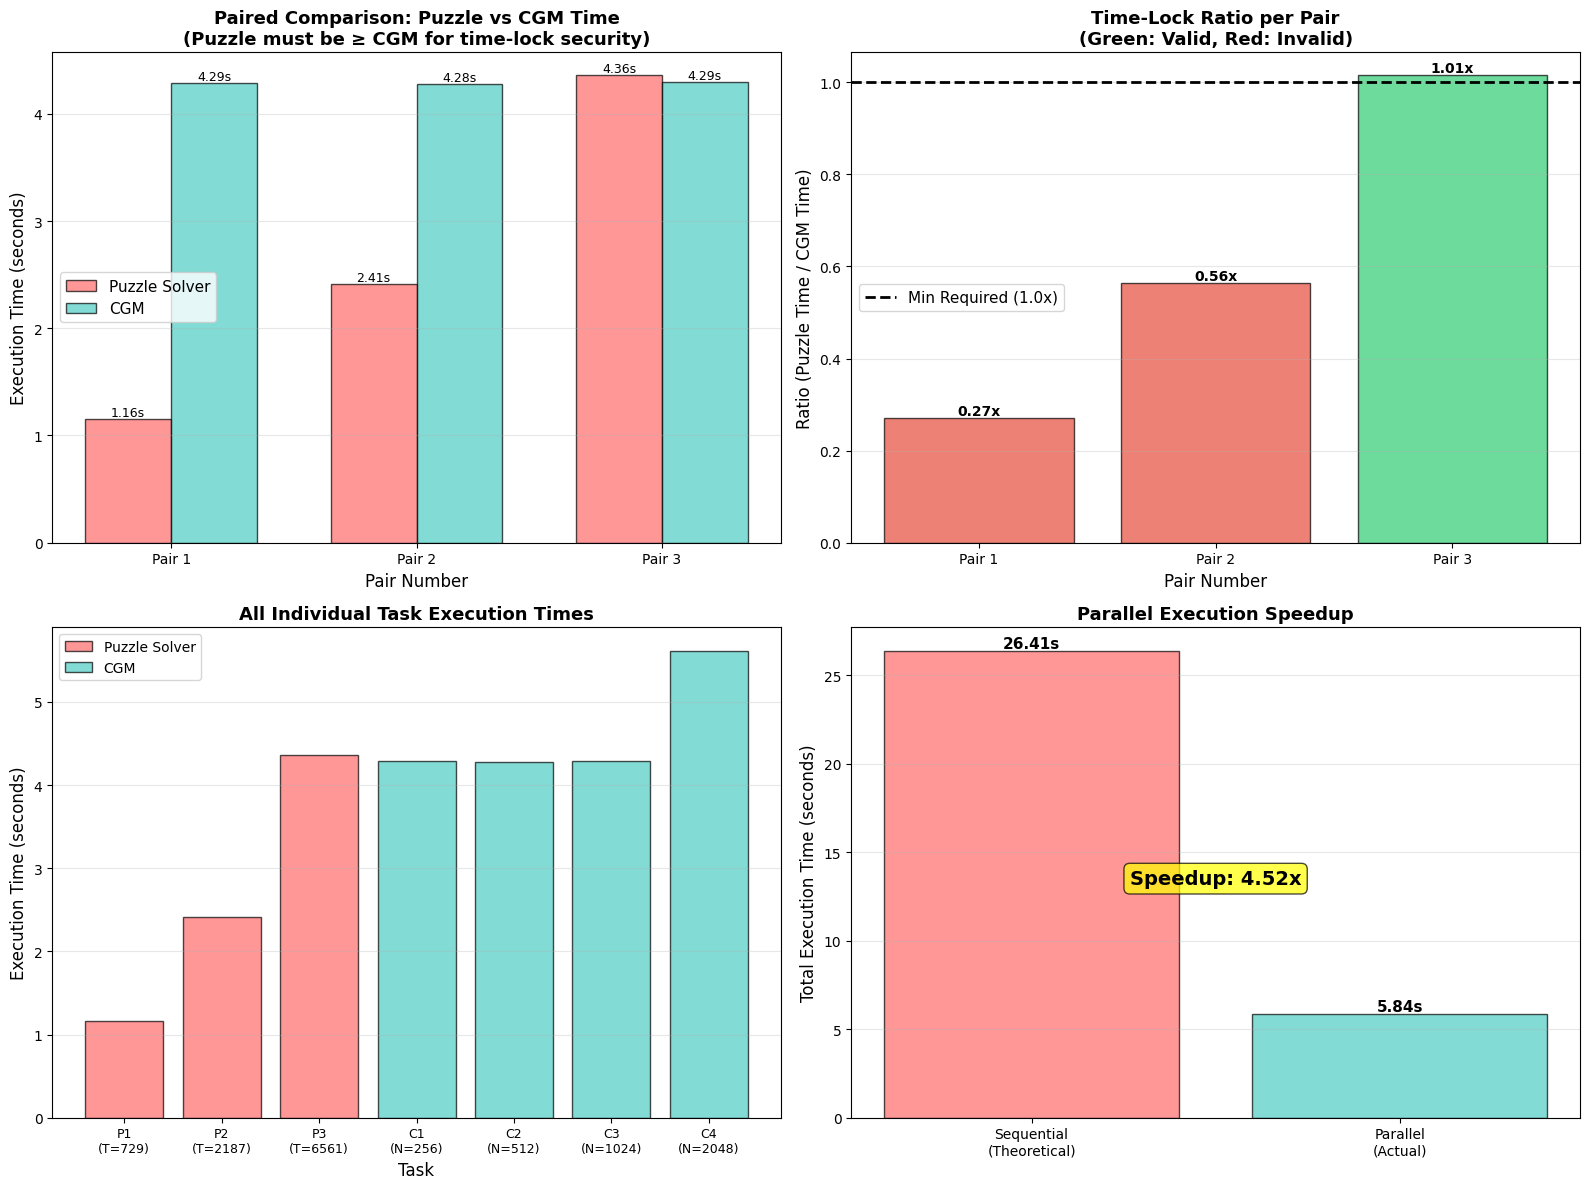

In [ ]:
# Enhanced visualization with paired comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Paired Puzzle vs CGM comparison
ax1 = axes[0, 0]
num_pairs = len(validation_results)
x_pairs = np.arange(num_pairs)
width = 0.35

puzzle_times_paired = [v['puzzle_time'] for v in validation_results]
cgm_times_paired = [v['cgm_time'] for v in validation_results]

bars1 = ax1.bar(x_pairs - width/2, puzzle_times_paired, width, label='Puzzle Solver', 
                color='#FF6B6B', alpha=0.7, edgecolor='black')
bars2 = ax1.bar(x_pairs + width/2, cgm_times_paired, width, label='CGM', 
                color='#4ECDC4', alpha=0.7, edgecolor='black')

ax1.set_xlabel('Pair Number', fontsize=12)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('Paired Comparison: Puzzle vs CGM Time\n(Puzzle must be ≥ CGM for time-lock security)', 
              fontsize=13, fontweight='bold')
ax1.set_xticks(x_pairs)
ax1.set_xticklabels([f'Pair {i+1}' for i in range(num_pairs)])
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add time values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}s',
                 ha='center', va='bottom', fontsize=9)

# Plot 2: Time ratio visualization
ax2 = axes[0, 1]
ratios = [v['ratio'] for v in validation_results]
colors_ratio = ['#2ECC71' if r >= 1.0 else '#E74C3C' for r in ratios]

bars = ax2.bar(x_pairs, ratios, color=colors_ratio, alpha=0.7, edgecolor='black')
ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Min Required (1.0x)')
ax2.set_xlabel('Pair Number', fontsize=12)
ax2.set_ylabel('Ratio (Puzzle Time / CGM Time)', fontsize=12)
ax2.set_title('Time-Lock Ratio per Pair\n(Green: Valid, Red: Invalid)', 
              fontsize=13, fontweight='bold')
ax2.set_xticks(x_pairs)
ax2.set_xticklabels([f'Pair {i+1}' for i in range(num_pairs)])
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Add ratio values on bars
for bar, ratio in zip(bars, ratios):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.2f}x',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Individual task execution times
ax3 = axes[1, 0]
puzzle_labels = [f"P{i+1}\n(T={r['T']})" for i, r in enumerate(experiment_results['puzzle_results'])]
cgm_labels = [f"C{i+1}\n(N={r['N']})" for i, r in enumerate(experiment_results['cgm_results'])]

x_pos = np.arange(len(puzzle_times) + len(cgm_times))
colors = ['#FF6B6B'] * len(puzzle_times) + ['#4ECDC4'] * len(cgm_times)
all_times = puzzle_times + cgm_times
all_labels = puzzle_labels + cgm_labels

bars = ax3.bar(x_pos, all_times, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Task', fontsize=12)
ax3.set_ylabel('Execution Time (seconds)', fontsize=12)
ax3.set_title('All Individual Task Execution Times', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(all_labels, fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.legend([bars[0], bars[len(puzzle_times)]], ['Puzzle Solver', 'CGM'], loc='upper left')

# Plot 4: Parallel vs Sequential comparison
ax4 = axes[1, 1]
execution_modes = ['Sequential\n(Theoretical)', 'Parallel\n(Actual)']
execution_times = [total_sequential, experiment_results['total_execution_time']]
colors_exec = ['#FF6B6B', '#4ECDC4']

bars = ax4.bar(execution_modes, execution_times, color=colors_exec, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Total Execution Time (seconds)', fontsize=12)
ax4.set_title('Parallel Execution Speedup', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels and speedup annotation
for bar, time_val in zip(bars, execution_times):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add speedup annotation
ax4.text(0.5, max(execution_times) * 0.5,
         f'Speedup: {parallel_speedup:.2f}x',
         ha='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

### Save Experiment Results

In [ ]:
# Save results to JSON file
output_filename = "parallel_experiment_results.json"

# Prepare data for JSON serialization
json_results = {
    'experiment_metadata': {
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'total_execution_time': experiment_results['total_execution_time'],
        'theoretical_sequential_time': total_sequential,
        'speedup_factor': parallel_speedup,
        'num_puzzle_tasks': len(puzzle_configs),
        'num_cgm_tasks': len(cgm_configs)
    },
    'puzzle_results': experiment_results['puzzle_results'],
    'cgm_results': experiment_results['cgm_results'],
    'summary': {
        'puzzle_avg_time': np.mean(puzzle_times),
        'cgm_avg_time': np.mean(cgm_times),
        'puzzle_total_time': np.sum(puzzle_times),
        'cgm_total_time': np.sum(cgm_times)
    }
}

with open(output_filename, 'w') as f:
    json.dump(json_results, f, indent=2)

print(f"✓ Results saved to '{output_filename}'")

✓ Results saved to 'parallel_experiment_results.json'


### Experiment Summary

This experiment demonstrates a **time-locked parallel computation** where:

1. **CGM Benchmarking**: Each linear system is solved using the Conjugate Gradient Method, and execution time is measured.

2. **T Calibration**: For each linear system, a time-lock puzzle parameter `T` is calculated such that:
   - Puzzle solving time ≥ CGM solving time
   - This ensures the time-lock constraint: you cannot bypass the CGM solution by solving the puzzle faster

3. **Parallel Execution**: Both puzzle solving and CGM algorithms run concurrently, demonstrating:
   - Efficient use of computational resources
   - Real-world speedup from parallelization
   - Validation that time-lock security is maintained

4. **Constraint Validation**: Post-execution analysis verifies that the time-lock property holds for each puzzle-CGM pair.

**Key Insight**: The time-lock puzzle acts as a computational delay mechanism - even with parallel execution, the puzzle cannot be solved faster than the corresponding linear system, providing cryptographic security through computational hardness.